In [1]:
import itertools
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scienceplots
import seaborn as sns

# plt.style.use(["science", "no-latex", "grid"])
sns.set_style("whitegrid")

In [2]:
def plot_impact(
    df,
    include_trade_probs=False,
    include_phi=True,
    include_loglog=False,
    warmup_ns=int(1e9) * 60 * 5,
):
    n_plots = 1 + int(include_phi) + int(include_trade_probs)

    fig = plt.figure(figsize=(15, 4 * n_plots + (3 if include_loglog else 0)))

    if include_loglog:
        gs = fig.add_gridspec(n_plots + 1, 1, height_ratios=[4] * n_plots + [2.5])
    else:
        gs = fig.add_gridspec(n_plots, 1)

    axes = [fig.add_subplot(gs[i]) for i in range(n_plots)]
    ax_idx = 0

    # Normalize time so warmup_ns = 1
    x = df["timestamp"] / warmup_ns

    # Row 1: avg_mid_price_change with 95% CI
    ax1 = axes[ax_idx]
    ax_idx += 1
    ax1.axvspan(0, 1, color="tab:blue", alpha=0.2)
    y1 = df["avg_mid_price_change"]
    se1 = df["mid_price_change_se"]
    ax1.fill_between(x, y1 - 1.96 * se1, y1 + 1.96 * se1, alpha=0.3)
    ax1.plot(x, y1, linewidth=2)
    ax1.set_xlabel("time (1 = warmup end)")
    ax1.set_ylabel(r"$E[P_t - P_0]$ in ticks")
    peak = df["avg_mid_price_change"].max()
    ax1_pct = ax1.twinx()
    ax1_pct.set_ylim(ax1.get_ylim()[0] / peak * 100, ax1.get_ylim()[1] / peak * 100)
    ax1_pct.set_ylabel("% of peak")

    # Row 2: avg_bias (phi) with 95% CI
    if include_phi:
        ax2 = axes[ax_idx]
        ax_idx += 1
        ax2.axvspan(0, 1, color="tab:blue", alpha=0.2)
        y2 = df["avg_bias"]
        se2 = df["bias_se"]
        ax2.fill_between(x, y2 - 1.96 * se2, y2 + 1.96 * se2, alpha=0.3)
        ax2.plot(x, y2, linewidth=2)
        ax2.set_xlabel("time (1 = warmup end)")
        ax2.set_ylabel(r"$\phi(t)$")

    if include_trade_probs:
        ax3 = axes[ax_idx]
        ax_idx += 1

        bid_cols = [c for c in df.columns if c.endswith("_bid_trade_prob")]
        ask_cols = [c for c in df.columns if c.endswith("_ask_trade_prob")]

        avg_bid = df.select(bid_cols).mean_horizontal()
        avg_ask = df.select(ask_cols).mean_horizontal()

        ax3.axvspan(0, 1, color="tab:blue", alpha=0.2)
        ax3.plot(x, avg_bid, linewidth=2, label="Avg Bid Trade Prob")
        ax3.plot(x, avg_ask, linewidth=2, label="Avg Ask Trade Prob")
        ax3.set_xlabel("time (1 = warmup end)")
        ax3.set_ylabel("trade probability")
        ax3.legend()
        ax3.set_title("Average Trade Probabilities Across All Bins")

        initial_bid = avg_bid[0]
        initial_ask = avg_ask[0]
        initial_avg = (initial_bid + initial_ask) / 2
        ax3_pct = ax3.twinx()
        ax3_pct.set_ylim(
            ax3.get_ylim()[0] / initial_avg * 100, ax3.get_ylim()[1] / initial_avg * 100
        )
        ax3_pct.set_ylabel("% of initial")

    if include_loglog:
        ax_log = fig.add_subplot(gs[n_plots])

        # Filter to execution period only (0 < t <= warmup_ns)
        exec_mask = (df["timestamp"] > 0) & (df["timestamp"] <= warmup_ns)
        exec_df = df.filter(exec_mask)

        t_exec = exec_df["timestamp"].to_numpy()
        impact_exec = exec_df["avg_mid_price_change"].to_numpy()

        # Filter positive values for log-log
        pos_mask = (t_exec > 0) & (impact_exec > 0)
        t_pos = t_exec[pos_mask]
        impact_pos = impact_exec[pos_mask]

        if len(t_pos) > 2:
            log_t = np.log(t_pos)
            log_impact = np.log(impact_pos)

            A = np.vstack([log_t, np.ones(len(log_t))]).T
            delta, c = np.linalg.lstsq(A, log_impact, rcond=None)[0]

            t_fit = np.linspace(t_pos.min(), t_pos.max(), 100)
            impact_fit = np.exp(c) * t_fit**delta

            ax_log.scatter(t_pos / 1e9, impact_pos, alpha=0.5, s=10, label="Data")
            ax_log.plot(
                t_fit / 1e9,
                impact_fit,
                "r--",
                linewidth=2,
                label=f"OLS fit: δ = {delta:.3f}",
            )
            ax_log.set_xscale("log")
            ax_log.set_yscale("log")
            ax_log.set_xlabel("time (seconds, log scale)")
            ax_log.set_ylabel("impact (ticks, log scale)")
            ax_log.legend()
            ax_log.set_title(f"Log-log: Impact ~ t^δ, δ = {delta:.3f}")
            ax_log.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return fig

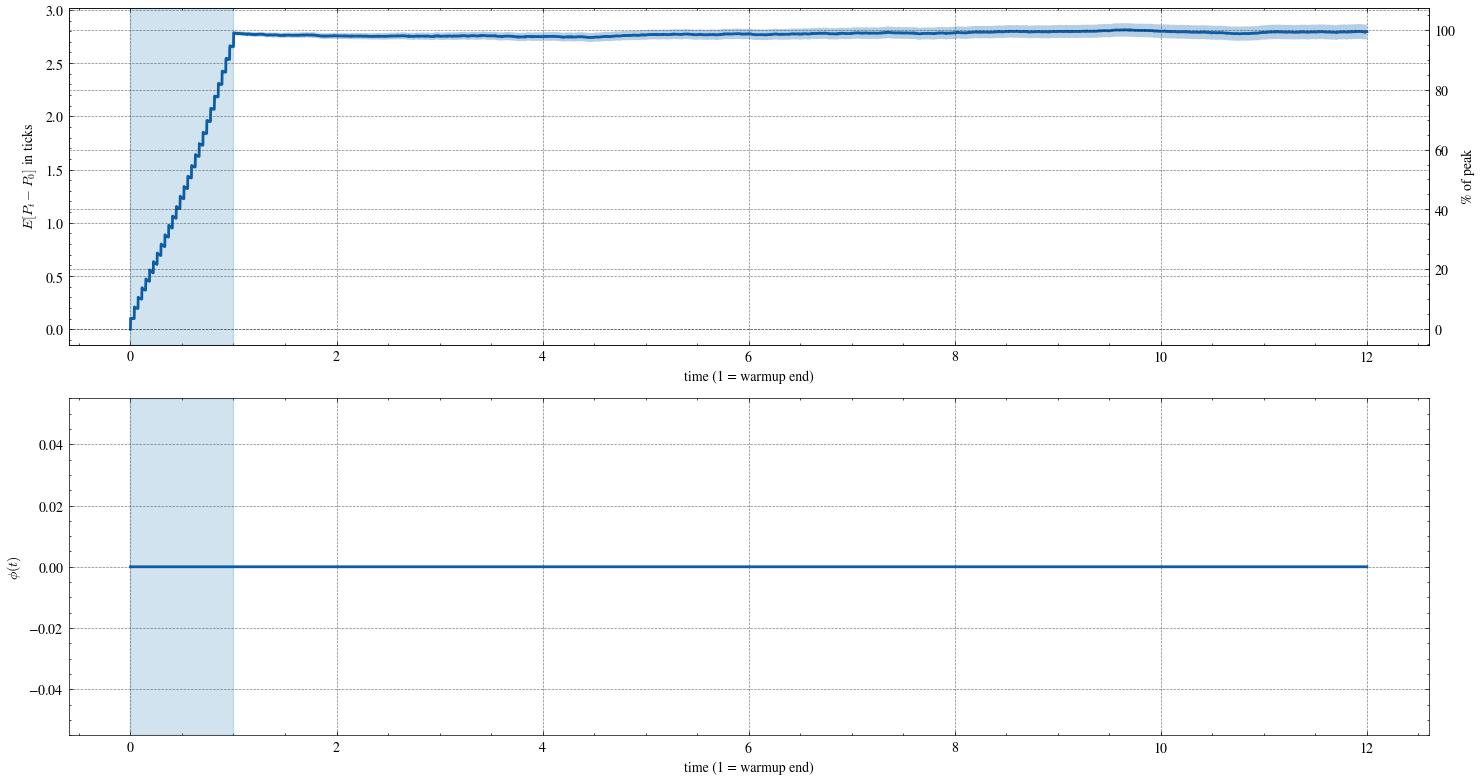

In [7]:
ticker = "PFE"
df = pl.read_csv(
    f"../data/results/PFE/no_impact_pct_100_exp.csv",
    infer_schema_length=10000,
)
fig = plot_impact(df, include_trade_probs=False)

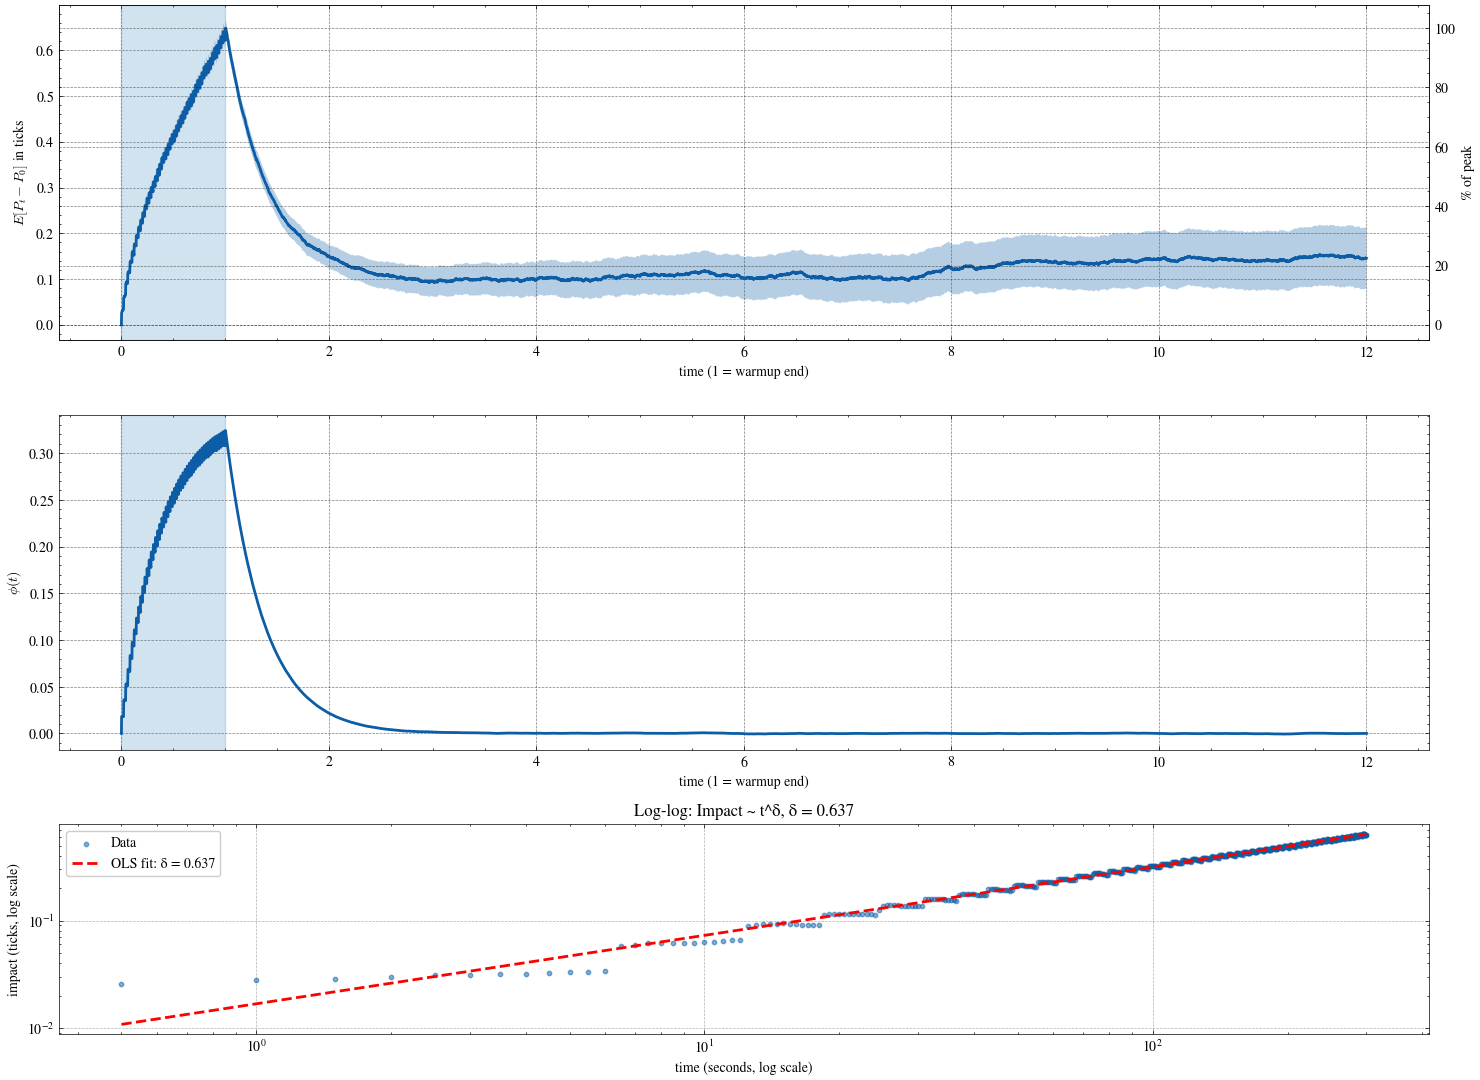

In [21]:
ticker = "PFE"
df = pl.read_csv(
    f"../data/results/{ticker}/timedecay_impact_pct_100_hl100_m0.013_exp.csv",
    infer_schema_length=10000,
)
fig = plot_impact(df, include_trade_probs=False, include_loglog=True, include_phi=True)

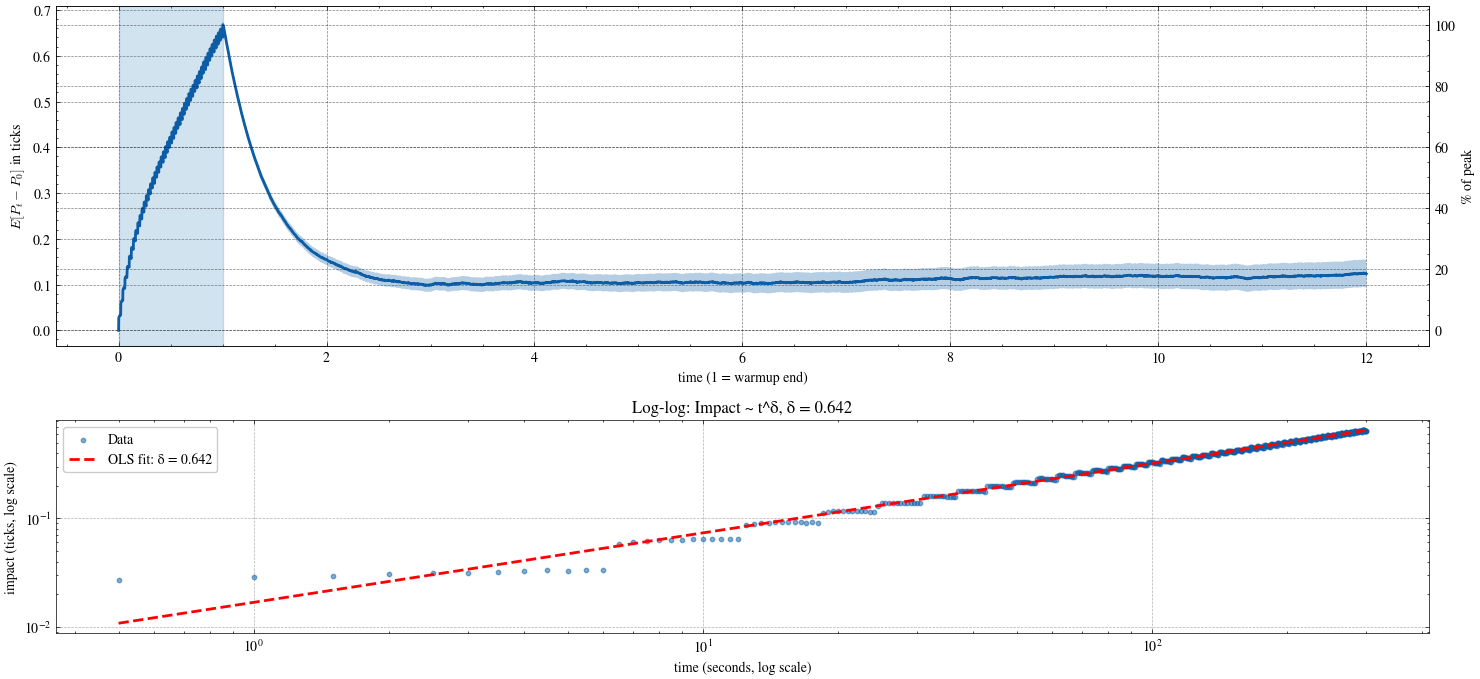

In [6]:
ticker = "PFE"
df = pl.read_csv(
    f"../data/results/{ticker}/timedecay_impact_pct_100_hl100_m0.0175_exp.csv",
    infer_schema_length=10000,
)
fig = plot_impact(df, include_trade_probs=False, include_loglog=True, include_phi=False)

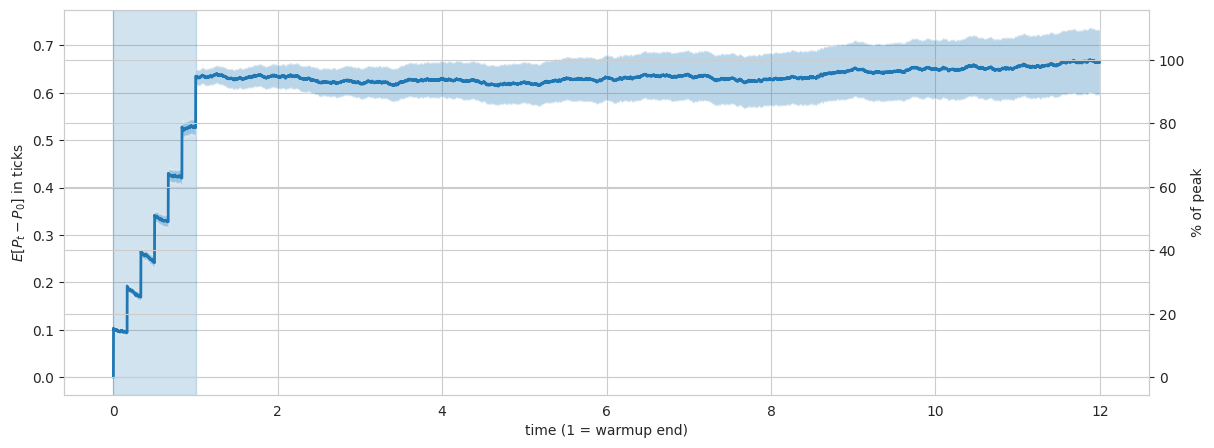

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 5))

df = pl.read_csv(
    f"../data/results/{ticker}/no_impact_pct_25_exp.csv",
    infer_schema_length=10000,
)
warmup_ns = int(1e9) * 60 * 5
# Normalize time so warmup_ns = 1
x = df["timestamp"] / warmup_ns

# Row 1: avg_mid_price_change with 95% CI
ax1.axvspan(0, 1, color="tab:blue", alpha=0.2)
y1 = df["avg_mid_price_change"]
se1 = df["mid_price_change_se"]
ax1.fill_between(x, y1 - 1.96 * se1, y1 + 1.96 * se1, alpha=0.3)
ax1.plot(x, y1, linewidth=2)
ax1.set_xlabel("time (1 = warmup end)")
ax1.set_ylabel(r"$E[P_t - P_0]$ in ticks")
peak = df["avg_mid_price_change"].max()
ax1_pct = ax1.twinx()
ax1_pct.set_ylim(ax1.get_ylim()[0] / peak * 100, ax1.get_ylim()[1] / peak * 100)
ax1_pct.set_ylabel("% of peak")

fig.savefig("../report/figures/no_impact_metaorder.pdf", bbox_inches="tight")
fig.savefig("../report/figures/no_impact_metaorder.png", bbox_inches="tight", dpi=300)

NameError: name 'pl' is not defined

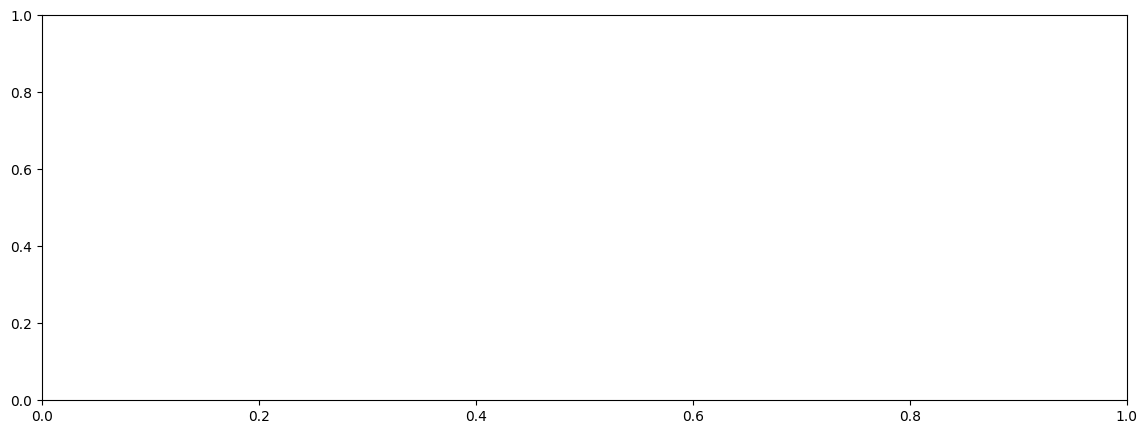

In [1]:
fig, ax1 = plt.subplots(figsize=(14, 5))
ticker = "PFE"
df = pl.read_csv(
    f"../data/results/{ticker}/ema_impact_pct_50_a0.01_m3_exp.csv",
    infer_schema_length=10000,
)
warmup_ns = int(1e9) * 60 * 5
# Normalize time so warmup_ns = 1
x = df["timestamp"] / warmup_ns

# Row 1: avg_mid_price_change with 95% CI
ax1.axvspan(0, 1, color="tab:blue", alpha=0.2)
y1 = df["avg_mid_price_change"]
se1 = df["mid_price_change_se"]
ax1.fill_between(x, y1 - 1.96 * se1, y1 + 1.96 * se1, alpha=0.3)
ax1.plot(x, y1, linewidth=2)
ax1.set_xlabel("time (1 = warmup end)")
ax1.set_ylabel(r"$E[P_t - P_0]$ in ticks")
peak = df["avg_mid_price_change"].max()
ax1_pct = ax1.twinx()
ax1_pct.set_ylim(ax1.get_ylim()[0] / peak * 100, ax1.get_ylim()[1] / peak * 100)
ax1_pct.set_ylabel("% of peak")

# fig.savefig("../report/figures/ema_impact_metaorder.pdf", bbox_inches="tight")
# fig.savefig("../report/figures/ema_impact_metaorder.png", bbox_inches="tight", dpi=300)

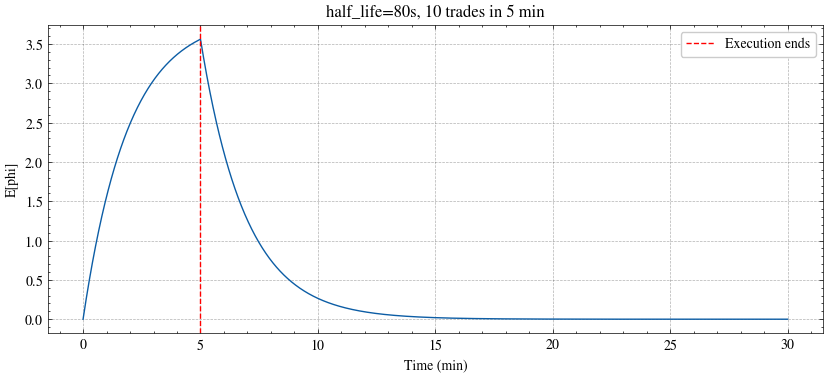

Peak phi: 3.56


In [22]:
half_life_sec = 80  # decay half-life in seconds
execution_duration = 5 * 60  # 5 min execution window
total_duration = 30 * 60  # 30 min total
total_trades = 10  # total trades during execution

# Derived
kappa = np.log(2) / half_life_sec
trade_rate = total_trades / execution_duration  # trades per second

# Time grid
t = np.arange(0, total_duration + 1, 1)

# Expected phi
phi = np.where(
    t <= execution_duration,
    (trade_rate / kappa) * (1 - np.exp(-kappa * t)),
    (trade_rate / kappa)
    * (1 - np.exp(-kappa * execution_duration))
    * np.exp(-kappa * (t - execution_duration)),
)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t / 60, phi)
plt.axvline(x=5, color="r", linestyle="--", label="Execution ends")
plt.xlabel("Time (min)")
plt.ylabel("E[phi]")
plt.title(
    f"half_life={half_life_sec}s, {total_trades} trades in {execution_duration//60} min"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Peak phi: {phi.max():.2f}")

In [3]:
ticker = "PFE"
df_impact = pl.read_csv(
    f"../data/results/{ticker}/timedecay_impact_pct_100_hl100_m0.013_exp.csv",
    infer_schema_length=10000,
)
df_no_impact = pl.read_csv(
    f"../data/results/{ticker}/no_impact_pct_100_exp.csv",
    infer_schema_length=10000,
)

In [4]:
df_impact = df_impact.with_columns(
    pl.col("avg_mid_price_change") / df_impact["avg_mid_price_change"].max(),
    pl.col("mid_price_change_se") / df_impact["avg_mid_price_change"].max(),
)
df_no_impact = df_no_impact.with_columns(
    pl.col("avg_mid_price_change") / df_no_impact["avg_mid_price_change"].max(),
    pl.col("mid_price_change_se") / df_impact["avg_mid_price_change"].max(),
)

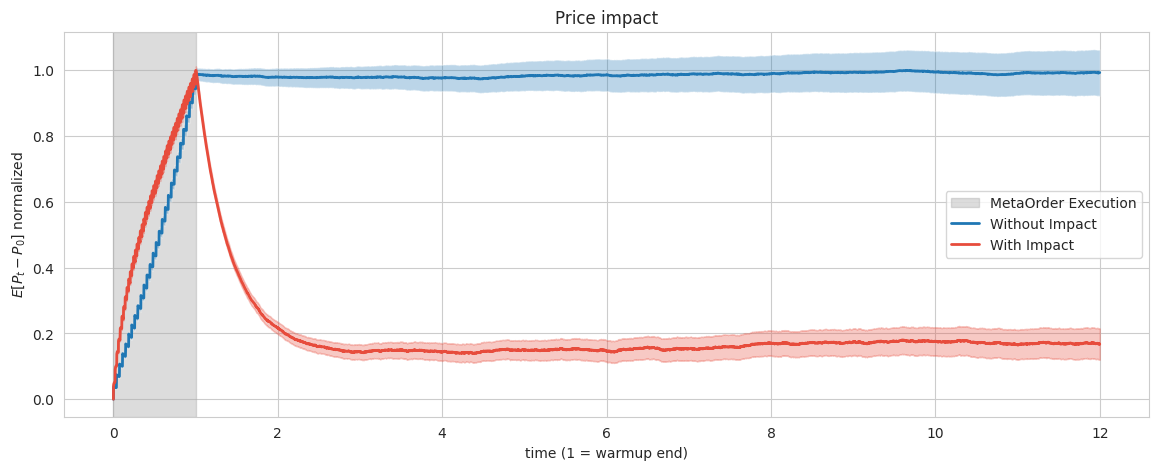

In [8]:
fig, ax = plt.subplots(figsize=(14, 5))

warmup_ns = int(1e9) * 60 * 5
x = df_impact["timestamp"] / warmup_ns

ax.axvspan(0, 1, color="darkgrey", alpha=0.4, label="MetaOrder Execution")

y_no_impact = df_no_impact["avg_mid_price_change"]
se_no_impact = df_no_impact["mid_price_change_se"]
ax.fill_between(
    x, y_no_impact - 1.96 * se_no_impact, y_no_impact + 1.96 * se_no_impact, alpha=0.3
)
ax.plot(x, y_no_impact, linewidth=2, label="Without Impact")
y_impact = df_impact["avg_mid_price_change"]
se_impact = df_impact["mid_price_change_se"]
ax.fill_between(
    x,
    y_impact - 1.96 * se_impact,
    y_impact + 1.96 * se_impact,
    alpha=0.3,
    color="#E74C3C",
)
ax.plot(x, y_impact, linewidth=2, label="With Impact", color="#E74C3C")
ax.set_xlabel("time (1 = warmup end)")
ax.set_ylabel(r"$E[P_t - P_0]$ normalized")

ax.set_title("Price impact")
plt.legend()
plt.show()
fig.savefig("../markdown/impact/impact_vs_time.pdf")

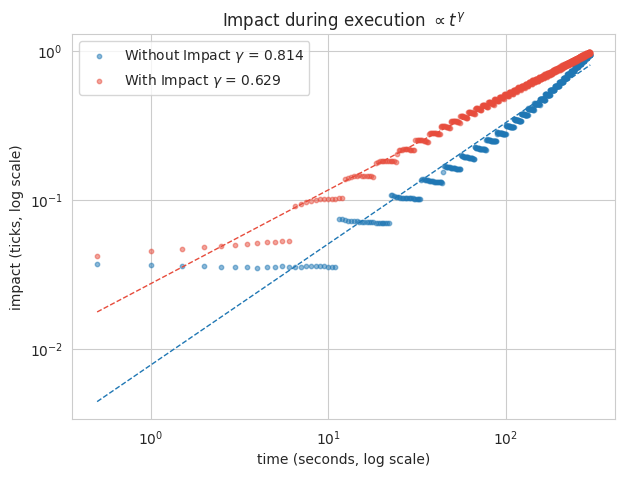

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))

exec_df_no_impact = df_no_impact.filter(pl.col("timestamp").le(warmup_ns))

t_exec_no_impact = exec_df_no_impact["timestamp"].to_numpy()
impact_exec_no_impact = exec_df_no_impact["avg_mid_price_change"].to_numpy()

# Filter positive values for log-log
pos_mask_no_impact = (t_exec_no_impact > 0) & (impact_exec_no_impact > 0)
t_pos_no_impact = t_exec_no_impact[pos_mask_no_impact]
impact_pos_no_impact = impact_exec_no_impact[pos_mask_no_impact]

log_t_no_impact = np.log(t_pos_no_impact)
log_impact_no_impact = np.log(impact_pos_no_impact)

A = np.vstack([log_t_no_impact, np.ones(len(log_t_no_impact))]).T
delta, c = np.linalg.lstsq(A, log_impact_no_impact, rcond=None)[0]

t_fit_no_impact = np.linspace(t_pos_no_impact.min(), t_pos_no_impact.max(), 100)
impact_fit_no_impact = np.exp(c) * t_fit_no_impact**delta

ax.scatter(
    t_pos_no_impact / 1e9,
    impact_pos_no_impact,
    alpha=0.5,
    s=10,
    label=rf"Without Impact $\gamma$ = {delta:.3f}",
)
ax.plot(
    t_fit_no_impact / 1e9,
    impact_fit_no_impact,
    "--",
    linewidth=1,
)

exec_df_impact = df_impact.filter(pl.col("timestamp").le(warmup_ns))

t_exec_impact = exec_df_impact["timestamp"].to_numpy()
impact_exec_impact = exec_df_impact["avg_mid_price_change"].to_numpy()

# Filter positive values for log-log
pos_mask_impact = (t_exec_impact > 0) & (impact_exec_impact > 0)
t_pos_impact = t_exec_impact[pos_mask_impact]
impact_pos_impact = impact_exec_impact[pos_mask_impact]

log_t_impact = np.log(t_pos_impact)
log_impact_impact = np.log(impact_pos_impact)

A = np.vstack([log_t_impact, np.ones(len(log_t_impact))]).T
delta, c = np.linalg.lstsq(A, log_impact_impact, rcond=None)[0]

t_fit_impact = np.linspace(t_pos_impact.min(), t_pos_impact.max(), 100)
impact_fit_impact = np.exp(c) * t_fit_impact**delta

ax.scatter(
    t_pos_impact / 1e9,
    impact_pos_impact,
    alpha=0.5,
    s=10,
    label=rf"With Impact $\gamma$ = {delta:.3f}",
    color='#E74C3C'
)
ax.plot(
    t_fit_impact / 1e9,
    impact_fit_impact,
    "--",
    linewidth=1,
    color='#E74C3C'
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("time (seconds, log scale)")
ax.set_ylabel("impact (ticks, log scale)")
ax.legend()
ax.set_title(r"Impact during execution $\propto t^\gamma$")

plt.show()
fig.savefig("../markdown/impact/linear_fit_execution.pdf")